# XGboost Boosting Trees

Extreme boosting is a sequential ensemble of algorithms. The model starts with a base estimator and each subsequent model in the series learns from the mistakes of its predecessor. The model learns slowly as it depends upon previous trees in the series

# Training Process

The model starts with an initial base model. The models fits on the residual errors of the previous model to update residuals. The subsequent model then performs better than its predecessor and this sequence continues until all predictors are trained. The ensemble then makes predictions by classifying the class that receives the most weighted votes. 

The model minimizes the residuals through gradient descent.



# XGBoost Hyperparameters

This model has many hyperparameters. They are classified into three categories.

**General parameters** relate to which booster we are using to do boosting, commonly tree or linear model

**Booster parameters** depend on which booster you have chosen

**Learning task parameters** decide on the learning scenario. For example, regression tasks may use different parameters with ranking tasks.

**Command line parameters** relate to behaviour of CLI version of XGBoost.



- n_estimators: Number of trees. Can overfit if this is too large

- learning rate: Shrinkage parameter. Setting this at a value too low will  require more trees but the model will generalize better. So, a low learning rate and high n_estimator works well.

- subsample: fraction of training instances to be used for training each tree. setting this at 0.25 means that each tree only uses 25% of the training instances selected randomly. This trades high bias for low variance. This is called stochastic gradient boosting.

- warm_start: early stopping call-back parameter if the model does not improve well for 5 consecutive iterations.





#  Pros and Cons


**Pros**

- Outperforms most other predictive models

- It is optimized for performance, making it highly scalable. 

**Cons**

- Trades better performance for lack of interpretability

- Works well with non-linear datasets

	



# 1. Libraries

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Import Data
dataset = pd.read_csv('Social_Network_Ads.csv')
dataset.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


# 2. Preprocessing

In [3]:
# Create subsets of input features and response variable.
X = dataset.iloc[:, :-1].values
y = dataset['Purchased'].values

# Training and Testing subsets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 911)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print('Standardized feature Mean:',  X_train.mean().round())
print('Standardized feature SD :',   X_train.std().round())

Standardized feature Mean: 0.0
Standardized feature SD : 1.0


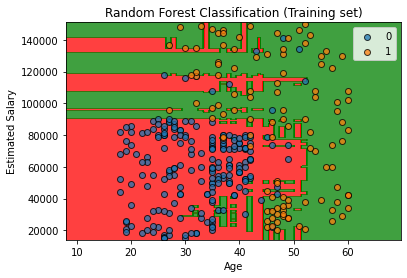

In [4]:
# Training the XGBoost Model
xgb = XGBClassifier(use_label_encoder=False, 
    eval_metric='error', # Evaluation metrics for validation data
    learning_rate =0.1, # Step size shrinkage to prevents overfitting.
    n_estimators=1000, # Number of Estimators
    max_depth=5, # Maximum depth of a tree.
    min_child_weight=1, #Minimum sum of instance weight (hessian) needed in a child.
    gamma=0, #Minimum loss reduction required to make a further partition on a leaf node of the tree.
    subsample=0.8, #fraction of training instances to be used for training each tree.
    colsample_bytree=0.8, # subsampling of columns.
    objective= 'binary:logistic', # tells XGBoost that we aim to train a logistic regression model
    nthread=4, #Number of parallel threads used to run XGBoost
    scale_pos_weight=1, # Control the balance of positive and negative weights, useful for unbalanced classes.
    seed=911) # For reproducible results

# Fit the model
xgb.fit(X_train, y_train)

# Visualising the Training set results
X_set, y_set = sc.inverse_transform(X_train), y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 0.25),
                     np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 0.25))
plt.contourf(X1, X2, xgb.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], cmap = ListedColormap(('red', 'green'))(i),edgecolor = 'black',
            linewidth = 1,
            alpha = 0.75, label = j)
plt.title('XGBoost Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

# 3. Model Evaluation

In [23]:
# Predicting a new result using age 40 and salary 87000
print(xgb.predict(sc.transform([[40,87000]])))
print(xgb.predict_proba(sc.transform([[40,87000]])))

# Predicting the Test set results
y_pred = xgb.predict(X_test)

# Classification Accuracy
print('Classification Accuracy :', accuracy_score(y_test, y_pred))

[0]
[[0.98690414 0.01309583]]
Classification Accuracy : 0.85


# 4. K-Fold Cross Validation

In [6]:
# 10 fold cross validation
accuracies = cross_val_score(estimator = xgb,
                             X = X,
                             y = y,
                             cv = 10,
                             scoring = 'accuracy')

# Cross validation accuracy and standard deviation
print(accuracies)
print("Accuracy: {:.3f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.3f} %".format(accuracies.std()*100))

[0.85  0.725 0.9   0.9   0.9   0.825 0.8   0.875 0.75  0.9  ]
Accuracy: 84.250 %
Standard Deviation: 6.230 %


# 5. Hyperparametric Tuning

In [16]:
# Grid Search CV
param_grid = [{"learning_rate": (0.05, 0.10, 0.15),
               "max_depth": [ 3, 4, 5, 6, 8],
               "min_child_weight": [ 1, 3, 5, 7],
               "gamma":[ 0.0, 0.1, 0.2],
               "colsample_bytree":[ 0.3, 0.4],
               "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}]

#Instantiate XGbBoost
xgboost_tuned = XGBClassifier(use_label_encoder=False)

# Configure GridSearchCV
grid_search = GridSearchCV(xgboost_tuned, param_grid, cv=5, scoring = "accuracy", n_jobs = -1)

# Initiate Search
grid_search.fit(X_train, y_train)

# Extract Tuned Parameters and Predictive Accuracy
tuned_params = grid_search.best_params_
tuned_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

# Print Results
print("Best Accuracy: {:.2f} %".format(grid_search.best_score_*100))
print("Best Parameters:", tuned_params)

Best Accuracy: 91.88 %
Best Parameters: {'colsample_bytree': 0.3, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}


In [19]:
# Randomized Search
xgb = XGBClassifier(use_label_encoder=False)

param_space = {"learning_rate": (0.05, 0.10, 0.15),
                "max_depth": [ 3, 4, 5, 6, 8],
                "min_child_weight": [ 1, 3, 5, 7],
                 "gamma":[ 0.0, 0.1, 0.2],
                "colsample_bytree":[ 0.3, 0.4],
                "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                "eval_metric": ['logloss']
}


# Configure GridSearchCV
random_search = RandomizedSearchCV(xgb, param_space, n_iter=32,
                                        scoring="accuracy", cv=5,
                                        n_jobs=-1, random_state=911)
# Initiate Search
random_search.fit(X_train, y_train)

# Extract Tuned Parameters and Predictive Accuracy
tuned_params = random_search.best_params_
tuned_score = random_search.best_score_
best_estimator = random_search.best_estimator_

# Print Results
print("Best Accuracy: {:.2f} %".format(random_search.best_score_*100))
print("Best Parameters:", tuned_params)

Best Accuracy: 90.94 %
Best Parameters: {'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'eval_metric': 'logloss', 'colsample_bytree': 0.4}


# 6. Evaluation Metrics

In [12]:

def evaluate_model(grid_search, X_test):
    
    y_pred = grid_search.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.6, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.6, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)
    
    
    # ROC/AUC Curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, c = 'green',
                linewidth = 3,
                alpha = 0.75)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    
    
    # Visualising the Testing Results
    X_set, y_set = sc.inverse_transform(X_test), y_test
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 0.25),
                         np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 0.25))
    plt.contourf(X1, X2, grid_search.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], cmap = ListedColormap(('red', 'green'))(i),edgecolor = 'black',
            linewidth = 1,
            alpha = 0.75, label = j)
    plt.title('XGBoost (Test set)')
    plt.xlabel('Age')
    plt.ylabel('Estimated Salary')
    plt.legend()
    plt.show()

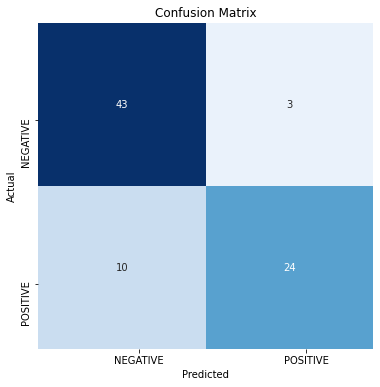

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.81      0.93      0.87        46
    POSITIVE       0.89      0.71      0.79        34

    accuracy                           0.84        80
   macro avg       0.85      0.82      0.83        80
weighted avg       0.84      0.84      0.83        80



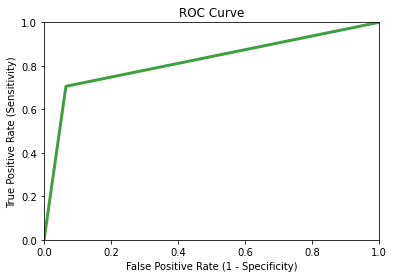

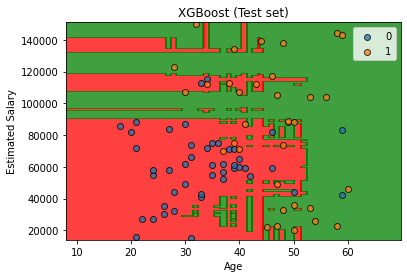

In [13]:
evaluate_model(grid_search, X_test)